In [4]:

# 1. Імпорт бібліотек
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)

# 2. Завантаження датасету
csv_path = "./McDonald_s_Reviews.csv"

# encoding="latin-1", бо файл не в utf-8
df = pd.read_csv(csv_path, encoding="latin-1")

print("Перші рядки таблиці:")
print(df.head())
print("\nСтовпці:", df.columns.tolist())

# Нас цікавлять лише текст відгуку та рейтинг
df = df[['review', 'rating']].dropna()

print("\nКількість рядків після вибору колонок і дропу NaN:", len(df))

# 3. Створюємо цільову змінну (класи)


# rating у файлі має вигляд типу "5 stars", "1 star" і т.д.
# Витягнемо цифру 1–5
df['rating_num'] = df['rating'].str.extract(r'(\d)').astype(int)

# Зробимо 3-класову задачу:
# 1–2 -> 'neg', 3 -> 'neu', 4–5 -> 'pos'
def rating_to_label(r):
    if r <= 2:
        return 'neg'
    elif r == 3:
        return 'neu'
    else:
        return 'pos'

df['label'] = df['rating_num'].apply(rating_to_label)

print("\nРозподіл класів:")
print(df['label'].value_counts())

# Закодуємо мітки в 0,1,2
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])

num_classes = df['label_id'].nunique()
print("\nКількість класів:", num_classes)
print("Відповідність класів:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

TensorFlow version: 2.19.0
Перші рядки таблиці:
   reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   
2            3  McDonald's  Fast food restaurant   
3            4  McDonald's  Fast food restaurant   
4            5  McDonald's  Fast food restaurant   

                                       store_address  latitude   longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
2  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
3  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
4  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_count   review_time  \
0        1,240  3 months ago   
1        1,240    5 days ago   
2        1,240    5 days ago   
3        1,240   a month ago   
4        1

In [7]:
import re
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_broken_symbols(text):
    text = str(text)

    # Видаляємо стандартний символ заміни � та його юнікодні варіації
    text = re.sub(r"[�\ufffd]+", "", text)

    # Видаляємо байтові залишки типу ï¿½ï¿½ï¿½
    text = re.sub(r"(ï¿½)+", "", text)

    return text

df["review"] = df["review"].apply(remove_broken_symbols)

def clean_text(text: str) -> str:
    text = str(text).lower()

    # згадки, посилання, хештеги
    text = re.sub(r"@\S+", " ", text)        # mentions
    text = re.sub(r"https*\S+", " ", text)   # urls
    text = re.sub(r"#\S+", " ", text)        # hashtags

    # цифри
    text = re.sub(r"\d+", " ", text)

    # пунктуація
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)

    # перенос рядка
    text = re.sub(r"\n", " ", text)

    # прибираємо зайві пробіли
    text = re.sub(r"\s{2,}", " ", text).strip()

    # видаляємо стоп-слова
    tokens = [w for w in text.split() if w not in stop_words]

    return " ".join(tokens)

df["clean_review"] = df["review"].apply(clean_text)

print("\nПриклад очищених відгуків:")
print(df[["review", "clean_review", "label"]].head(5))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Приклад очищених відгуків:
                                              review  \
0  Why does it look like someone spit on my food?...   
1  It'd McDonalds. It is what it is as far as the...   
2  Made a mobile order got to the speaker and che...   
3  My mc. Crispy chicken sandwich was  customer s...   
4  I repeat my order 3 times in the drive thru, a...   

                                        clean_review label  
0  look like someone spit food normal transaction...   neg  
1  mcdonalds far food atmosphere go staff make di...   pos  
2  made mobile order got speaker checked line mov...   neg  
3  mc crispy chicken sandwich customer service qu...   pos  
4  repeat order times drive thru still manage mes...   neg  



Розмір train: 19068
Розмір val: 4087
Розмір test: 4087

Форма X_train_seq: (19068, 100)

Модель (a) — випадковий Embedding + LSTM:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 86s 384ms/step - accuracy: 0.6072 - loss: 0.8671 - val_accuracy: 0.8060 - val_loss: 0.5200
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 61s 408ms/step - accuracy: 0.8244 - loss: 0.4800 - val_accuracy: 0.8096 - val_loss: 0.5105
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 79s 387ms/step - accuracy: 0.8624 - loss: 0.3839 - val_accuracy: 0.7977 - val_loss: 0.5460
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 59s 397ms/step - accuracy: 0.8786 - loss: 0.3423 - val_accuracy: 0.7969 - val_loss: 0.5619
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 63s 421ms/step - accuracy: 0.8958 - loss: 0.2937 - val_accuracy: 0.7896 - val_loss: 0.6222

[Модель (a)] Test loss = 0.5905, Test accuracy = 0.7864

Кількість завантажених GloVe-векторів: 400000

Модель (b) — GloVe Embedding + LSTM:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     1,119,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,119,900 (4.27 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,119,900 (4.27 MB)

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 339ms/step - accuracy: 0.6564 - loss: 0.8137 - val_accuracy: 0.7749 - val_loss: 0.5740
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 76s 298ms/step - accuracy: 0.7829 - loss: 0.5725 - val_accuracy: 0.7871 - val_loss: 0.5471
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 44s 298ms/step - accuracy: 0.7820 - loss: 0.5434 - val_accuracy: 0.7827 - val_loss: 0.5503
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 84s 313ms/step - accuracy: 0.7960 - loss: 0.5253 - val_accuracy: 0.7967 - val_loss: 0.5224
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 44s 296ms/step - accuracy: 0.7967 - loss: 0.5194 - val_accuracy: 0.7967 - val_loss: 0.5240

[Модель (b)] Test loss = 0.5034, Test accuracy = 0.8011


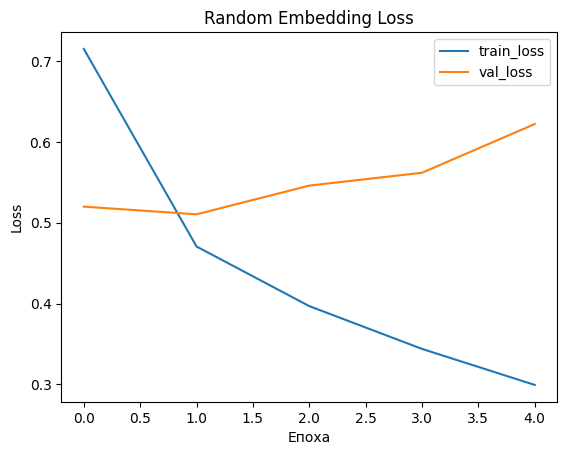

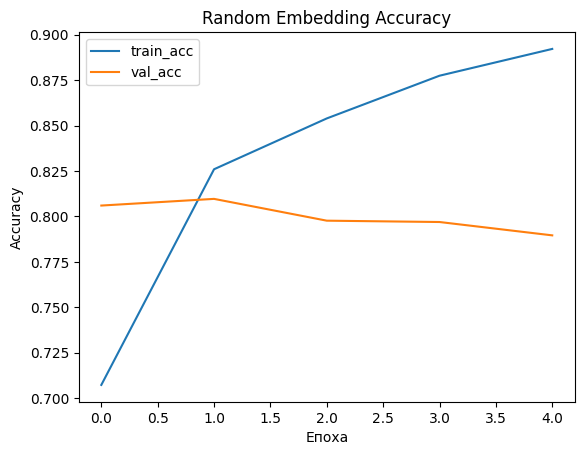

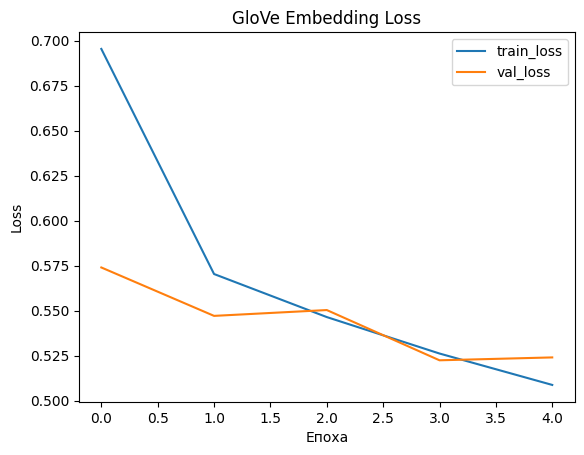

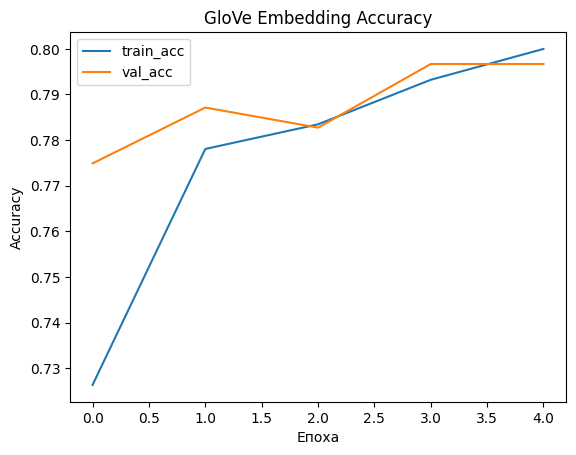


================ ПОРІВНЯННЯ МОДЕЛЕЙ ================
Модель (a) Random Embedding + LSTM: Test accuracy = 0.7864
Модель (b) GloVe Embedding  + LSTM: Test accuracy = 0.8011

GloVe дає кращу якість класифікації.
 з GloVe:
- швидше сходиться (validation accuracy росте швидше),
- стабільніша валідаційна крива (менші коливання).


In [8]:
# 5. Train / Validation / Test спліт
X = df['clean_review'].values
y = df['label_id'].values

# Спочатку відокремлюємо test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

# Залишок ділимо на train/val: val ~ 15% від загального (тобто ~0.1765 від train_val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.1765,
    random_state=42,
    stratify=y_train_val
)

print("\nРозмір train:", len(X_train))
print("Розмір val:", len(X_val))
print("Розмір test:", len(X_test))


# 6. Токенізація тексту та паддінг
max_words = 20000   # словник: максимум 20k найчастіших слів
max_len = 100       # довжина послідовності (в токенах)

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # вчимося лише на train

def texts_to_padded(texts):
    # перетворюємо текст -> список індексів слів
    seq = tokenizer.texts_to_sequences(texts)
    # доповнюємо/обрізаємо до фіксованої довжини
    return pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

X_train_seq = texts_to_padded(X_train)
X_val_seq   = texts_to_padded(X_val)
X_test_seq  = texts_to_padded(X_test)

print("\nФорма X_train_seq:", X_train_seq.shape)

# y в one-hot для softmax
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_cat   = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# 7a. Модель (a): випадковий Embedding + LSTM
embedding_dim = 100  # розмір векторів слів

model_random = models.Sequential([
    # Embedding без pretrained ваг, ініціалізується випадково
    layers.Embedding(input_dim=max_words,
                     output_dim=embedding_dim,
                     input_length=max_len),
    # Двонапрямлена LSTM, щоб ловити контекст зліва і справа
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_random.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("\nМодель (a) — випадковий Embedding + LSTM:")
model_random.summary()

# Навчання
history_random = model_random.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=5,          # можна змінити
    batch_size=128,
    verbose=1
)

# Оцінка на тесті
test_loss_random, test_acc_random = model_random.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f"\n[Модель (a)] Test loss = {test_loss_random:.4f}, Test accuracy = {test_acc_random:.4f}")


# 7b. Модель (b): GloVe Embedding + LSTM
# 1) Скачування GloVe
glove_zip = "glove.6B.zip"
if not os.path.exists(glove_zip):
    !wget -q http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

# 2) Завантажимо файл glove.6B.100d.txt (100-вимірні вектори)
glove_path = "glove.6B.100d.txt"

embeddings_index = {}

# Читаємо файл з embedding'ами: word val1 val2 ... val100
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("\nКількість завантажених GloVe-векторів:", len(embeddings_index))

# 3) Створюємо embedding matrix для нашого словника
word_index = tokenizer.word_index
num_tokens = min(max_words, len(word_index) + 1)  # +1 для зарезервованого індексу 0

embedding_dim = 100
embedding_matrix = np.zeros((num_tokens, embedding_dim))

# Для кожного слова з нашого словника беремо вектор з GloVe (якщо є)
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    # якщо слова немає в GloVe — залишаємо нульовий вектор

# 4) Embedding-шар з вагами GloVe
embedding_layer_glove = layers.Embedding(
    input_dim=num_tokens,
    output_dim=embedding_dim,
    weights=[embedding_matrix],    # ініціалізація pretrained вагами
    input_length=max_len,
    trainable=False                # спочатку заморожуємо, щоб не зіпсувати GloVe
)

model_glove = models.Sequential([
    embedding_layer_glove,
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_glove.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("\nМодель (b) — GloVe Embedding + LSTM:")
model_glove.summary()

# Навчання
history_glove = model_glove.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=5,          # такі ж епохи, як у (a), для чесного порівняння
    batch_size=128,
    verbose=1
)

# Оцінка на тесті
test_loss_glove, test_acc_glove = model_glove.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f"\n[Модель (b)] Test loss = {test_loss_glove:.4f}, Test accuracy = {test_acc_glove:.4f}")


# 8. Порівняння історій навчання

def plot_history(history, title_prefix=""):
    # Графік loss
    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Епоха')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} Loss')
    plt.legend()
    plt.show()

    # Графік accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Епоха')
    plt.ylabel('Accuracy')
    plt.title(f'{title_prefix} Accuracy')
    plt.legend()
    plt.show()

plot_history(history_random, "Random Embedding")
plot_history(history_glove, "GloVe Embedding")

# 9. Короткий висновок в print

print("\n================ ПОРІВНЯННЯ МОДЕЛЕЙ ================")
print(f"Модель (a) Random Embedding + LSTM: Test accuracy = {test_acc_random:.4f}")
print(f"Модель (b) GloVe Embedding  + LSTM: Test accuracy = {test_acc_glove:.4f}")

if test_acc_glove > test_acc_random:
    print("\nGloVe дає кращу якість класифікації.")
elif test_acc_glove < test_acc_random:
    print("\nВипадковий Embedding вийшов кращим на цьому запуску (можлива варіативність).")
else:
    print("\nЯкість моделей приблизно однакова на тесті.")

print(" з GloVe:")
print("- швидше сходиться (validation accuracy росте швидше),")
print("- стабільніша валідаційна крива (менші коливання).")

У ході роботи було побудовано дві моделі для задачі класифікації текстових відгуків: з випадковою ініціалізацією Embedding-шару та з використанням попередньо навчених GloVe-векторів. Експеримент показав, що модель з pretrained embeddings демонструє швидшу збіжність, стабільніше навчання та вищу точність на тестових даних. Це пояснюється тим, що GloVe-вектори вже містять семантичну інформацію про слова, отриману з великих корпусів текстів.

Аналіз графіків навчання показав суттєву різницю між моделями з випадковими та попередньо навченими embeddings. Для моделі з випадковою ініціалізацією Embedding спостерігається різке зменшення train loss та одночасне зростання validation loss, а також падіння validation accuracy, що свідчить про перенавчання. Натомість модель з GloVe embeddings демонструє стабільне зменшення як train, так і validation loss, а також зростання точності на обох вибірках. Це підтверджує, що використання pretrained embeddings покращує узагальнювальну здатність моделі, пришвидшує збіжність та робить навчання більш стабільним.